In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd

%matplotlib notebook

def exp_chirp(duration=2, sr=2**14, f0=110, gamma=0.5):
    t = torch.arange(0, duration, 1/sr)
    phi = f0 / (gamma*np.log(2)) * (2 ** (gamma*t) - 1)
    return torch.sin(2*np.pi*phi)


def sinusoid(duration=2, sr=2**14, f0=110):
    t = torch.arange(0, duration, 1/sr)
    return torch.sin(2 * np.pi * f0 * t)


def generate(f_c, f_m, gamma=0.5, duration=2, sr=2**14):
    x_c = exp_chirp(duration=duration, sr=sr, gamma=gamma, f0=f_c) # carrier chirp
    x_m = sinusoid(duration, sr=sr, f0=f_m)
    x = x_c * x_m * torch.hann_window(duration * sr)
    return x


def plot(x, sr=2**14):
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    librosa.display.waveshow(x.numpy(), sr=sr, ax=axes[0])
    axes[0].set_title("Waveplot of the signal")
    hop_length=256
    C = librosa.cqt(
        x.numpy(),
        fmin=55, bins_per_octave=12, n_bins=72, sr=sr, hop_length=hop_length)
    librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(C)),
        x_axis="time", sr=sr, hop_length=hop_length,
        y_axis="cqt_hz", bins_per_octave=12,
        ax=axes[1])
    axes[1].set_title("Time-Frequency Spectrogram of the signal")
    fig.tight_layout()
    
def disp_audio(x, rate=2**14):
    return ipd.Audio(x, rate=rate, autoplay=True)

## Amplitude-modulated Chirp Synthesis

<IPython.core.display.Javascript object>


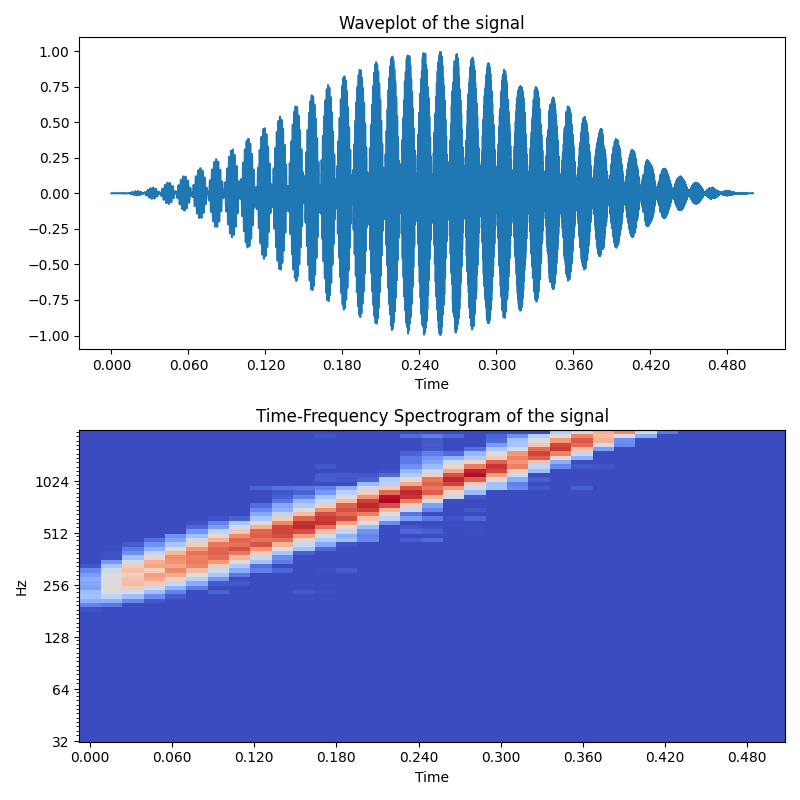

In [23]:
x = generate(f_c=200, f_m=20, gamma=4, duration=1, sr=2**13)
plot(x)
disp_audio(x)

In [19]:
import tqdm

f0s = np.logspace(np.log10(100), np.log10(200), 16)
fms = np.logspace(np.log10(4), np.log10(32), 16)
gammas = np.logspace(np.log10(0.5), np.log10(4), 16)

duration, sr = 1, 2**13

audio = torch.zeros(len(f0s), len(fms), len(gammas), duration * sr)
cmap = torch.zeros(3, len(f0s) * len(fms) * len(gammas))
c = 0
for i, f0 in tqdm.tqdm(enumerate(f0s)):
    for j, fm in enumerate(fms):
        for k, gamma in enumerate(gammas):
            audio[i, j, k] = generate(f0, fm, gamma, sr=sr, duration=duration)
            cmap[0, c], cmap[1, c], cmap[2, c] = f0, fm, gamma
            c += 1
            
X = audio.view(-1, audio.shape[-1])

16it [00:01,  9.25it/s]


## Joint Time-Frequency Scattering

In [44]:
from kymatio.torch import TimeFrequencyScattering1D
import time

N = duration * sr

jtfs = TimeFrequencyScattering1D(
    shape=(N, ),
    T=N,
    Q=8,
    J=12,
    max_pad_factor=1, 
    out_3D=True,
    max_pad_factor_fr=1).cuda()

In [21]:
n_samples = X.shape[0]
n_paths = jtfs(X[0]).shape[1]
sx = torch.zeros(n_samples, n_paths)

for i in tqdm.tqdm(range(n_samples)):
    sx[i, :] = jtfs(X[i, :])[:, :, 0]

100%|██████████████████████████████████████████████████████████████████████████████████| 4096/4096 [09:58<00:00,  6.84it/s]


0.2144489288330078


<IPython.core.display.Javascript object>


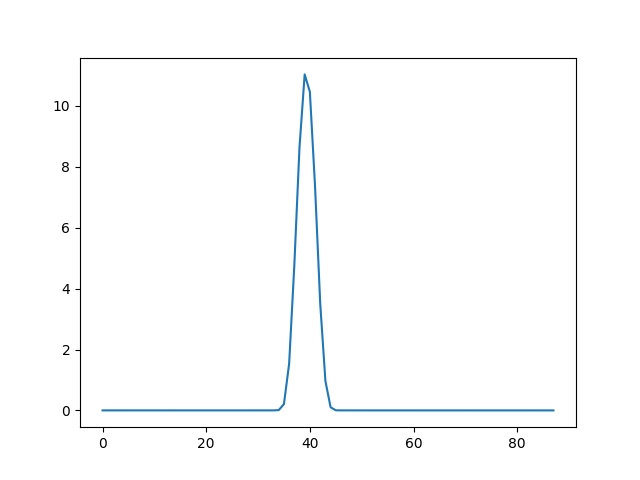

In [26]:
%matplotlib notebook
start = time.time()

sx = jtfs(X[0, :].cuda())
print(time.time() - start)
plt.plot(sx[0].cpu().numpy().ravel())

In [51]:
help(TimeFrequencyScattering1D)

Help on class TimeFrequencyScattering1D in module kymatio.torch:

class TimeFrequencyScattering1D(kymatio.scattering1d.frontend.base_frontend.TimeFrequencyScatteringBase1D, Scattering1D)
 |  TimeFrequencyScattering1D(J, shape, Q, J_fr=None, Q_fr=2, T=None, F=None, implementation=None, average=True, average_fr=False, oversampling=0, oversampling_fr=None, aligned=True, sampling_filters_fr=('exclude', 'resample'), out_type='array', out_3D=False, out_exclude=None, pad_mode='reflect', max_pad_factor=2, max_pad_factor_fr=None, pad_mode_fr='conj-reflect-zero', analytic=True, r_psi=0.7071067811865476, backend='torch')
 |  
 |  The 1D Joint Time-Frequency Scattering transform.
 |  
 |  JTFS builds on time scattering by convolving first order coefficients
 |  with joint 2D wavelets along time and frequency, increasing discriminability
 |  while preserving time-shift invariance. Invariance to frequency transposition
 |  can be imposed via frequential averaging, while preserving sensitivity to
 | 

In [82]:
(jtfs.meta()[1]['xi'] * sr)[:,5,1]

array([   0.        , 3393.23750296, 2399.38124852, 1696.61875148,
       1199.69062426,  848.30937574,  599.84531213,  424.15468787,
        299.92265606,  212.07734394,  149.96132803,  106.03867197,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        , 3393.23750296, 2399.38124852, 1696.61875148,
       1199.69062426,  848.30937574, 3393.23750296, 2399.38124852,
       1696.61875148, 1199.69062426,  848.30937574,  599.84531213,
        424.15468787, 3393.23750296, 2399.38124852, 1696.61875148,
       1199.69062426,  848.30937574,  599.84531213,  424.15468787,
        299.92265606, 3393.23750296, 2399.38124852, 1696.61875148,
       1199.69062426,  848.30937574,  599.84531213,  424.15468787,
        299.92265606, 3393.23750296, 2399.38124852, 1696.61875148,
       1199.69062426,  848.30937574,  599.84531213,  424.15468787,
        299.92265606,  212.07734394, 3393.23750296, 2399.38124

In [87]:
(jtfs.meta()[1]['xi'])[:,0,0]*sr

array([  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. , 409.6, 204.8, 102.4,  51.2,  25.6,  12.8,
         6.4,   3.2,   1.6, 409.6, 409.6, 409.6, 409.6, 409.6, 204.8,
       204.8, 204.8, 204.8, 204.8, 204.8, 204.8, 102.4, 102.4, 102.4,
       102.4, 102.4, 102.4, 102.4, 102.4,  51.2,  51.2,  51.2,  51.2,
        51.2,  51.2,  51.2,  51.2,  25.6,  25.6,  25.6,  25.6,  25.6,
        25.6,  25.6,  25.6,  25.6,  12.8,  12.8,  12.8,  12.8,  12.8,
        12.8,  12.8,  12.8,  12.8,   6.4,   6.4,   6.4,   6.4,   6.4,
         6.4,   6.4,   6.4,   6.4,   6.4,   3.2,   3.2,   3.2,   3.2,
         3.2,   3.2,   3.2,   3.2,   3.2,   3.2,   1.6,   1.6,   1.6,
         1.6,   1.6,   1.6,   1.6,   1.6,   1.6,   1.6,   1.6, 409.6,
       409.6, 409.6, 409.6, 409.6, 204.8, 204.8, 204.8, 204.8, 204.8,
       204.8, 204.8, 102.4, 102.4, 102.4, 102.4, 102.4, 102.4, 102.4,
       102.4,  51.2,  51.2,  51.2,  51.2,  51.2,  51.2,  51.2,  51.2,
        25.6,  25.6,

### Manifold embedding of the nearest neighbour graph

In [33]:
def plot_isomap(Y, cmap):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[0], cmap='bwr');
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # f modulator
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[1], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # chirp rate
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[2], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)

<IPython.core.display.Javascript object>


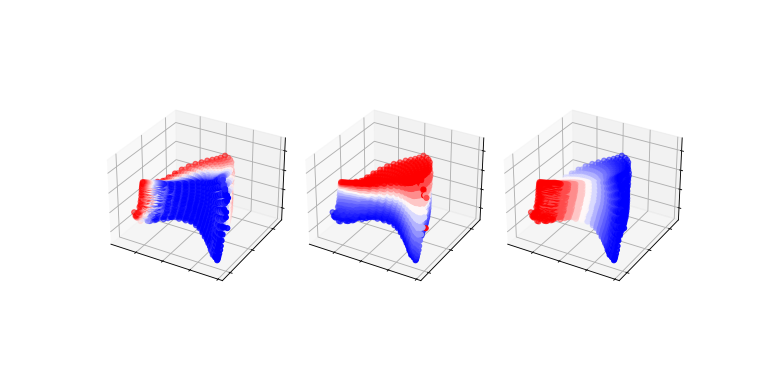

In [34]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(sx)
plot_isomap(Y, cmap)

## Open-L3

In [ ]:
import openl3

X_ol3, _ = openl3.get_audio_embedding(
    list(X.numpy()), 
    sr, 
    batch_size=32,
    frontend='kapre',
    content_type='music')

 29/768 [>.............................] - ETA: 41:14

### Manifold embedding of the nearest neighbour graph

/homes/cv300/venvs/dafx/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/homes/cv300/venvs/dafx/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/homes/cv300/venvs/dafx/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/homes/cv300/venvs/dafx/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.

<IPython.core.display.Javascript object>


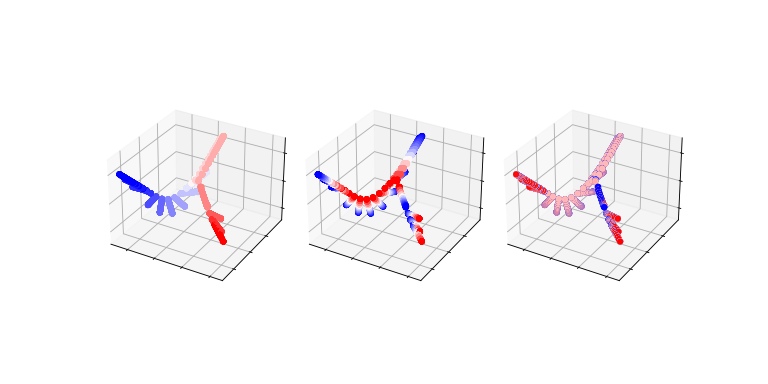

In [35]:
X_ol3 = np.load('/homes/cv300/Documents/scattering/data/openl3.npy')
cmap = X_ol3 = np.load('/homes/cv300/Documents/scattering/data/cmap.npy')

embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(X_ol3)
plot_isomap(Y, cmap.T)

In [37]:
sx.shape


torch.Size([4096, 8141])

In [165]:
import torch
jtfs = TimeFrequencyScattering1D(
    shape=(2**17, ),
    T=2**12,
    Q=16,
    J=12,
    F=4,
    average_fr=True,
    max_pad_factor=1, 
    out_3D=True,
    max_pad_factor_fr=1).cuda()
dummy = torch.randn(2**17)
jtfs(dummy)[1].shape

torch.Size([1, 234, 39, 32])

In [167]:
Sx = jtfs(dummy)

In [166]:
import torch.nn.functional as F
avg_o1 = F.avg_pool2d(Sx[0].unsqueeze(1), kernel_size=(4, 1), padding=(0, 0))

torch.cat([avg_o1, F.pad(Sx[1], (0, 0, 0, 1))], dim=-3).shape

torch.Size([1, 131, 24, 32])

In [135]:
avg_o1.shape

torch.Size([1, 1, 24, 32])

In [170]:
import torch.nn as nn
conv2d_in = Sx[0].unsqueeze(1)
conv1 = nn.Conv2d(1, 4, kernel_size=(16, 1)).cuda()
convs1=F.avg_pool2d(F.relu(conv1(conv2d_in)), kernel_size=(4, 1), padding=(2, 0))
s1_out = F.pad(convs1, (0, 0, Sx[1].shape[-2] - convs1.shape[-2], 0))
torch.cat([s1_out, Sx[1]], dim=-3)[:, :, :32, :].size()

torch.Size([1, 238, 32, 32])

In [156]:
Sx[1].shape

torch.Size([1, 130, 23, 32])

In [157]:
avg_o1.shape

torch.Size([1, 1, 24, 32])